In [50]:
import pandas as pd
# import glob
# from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import joblib
from tabulate import tabulate
import os

# # data science libraries
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold 
# from sklearn.impute import KNNImputer
# from sklearn.linear_model import LogisticRegression
# # from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.metrics import precision_recall_curve, auc
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import classification_report
# from sklearn.model_selection import cross_val_score
# from xgboost import XGBClassifier

In [51]:
rng = np.random.RandomState(42)

In [52]:
def save_df_to_csv(df, filepath) -> None:
    """
    Saves a Pandas DataFrame to a CSV file, creating the directory if it doesn't exist.

    Args:
        df (pd.DataFrame): The DataFrame to save.
        filepath (str): The full path to the CSV file.
    """
    directory = os.path.dirname(filepath)
    if directory:
        os.makedirs(directory, exist_ok=True)
    df.to_csv(filepath, index=False)

def get_df_head_tail_shape(df: pd.DataFrame) -> None:
    """
    Print the information of a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to print its head, tail, shape.
    
    Returns:
    None
    """
    
    print("\nDataFrame Shape:")
    print(df.shape)
    print("\nDataFrame Head:")
    print(tabulate(df.head(), headers='keys', tablefmt='pretty', showindex=False, floatfmt=".2f"))
    print("\nDataFrame Tail:")
    print(tabulate(df.tail(), headers='keys', tablefmt='pretty', showindex=False, floatfmt=".2f"))

def get_X_y(df):
    """
    Split the DataFrame (train, test, holdout) into features (X) and target variable (y).
    
    Parameters:
    df (pd.DataFrame): The DataFrame to split.
    
    Returns:
    X (pd.DataFrame): Features DataFrame.
    y (pd.Series): Target variable Series.
    """
    target_var = 'In-hospital_death'
    X = df.drop(columns=[target_var]) # features
    y = df[target_var] # target
    
    return X, y

def get_train_test_holdout(X, y, test_size=0.2, holdout_size=0.2):
    """
    Split the data into train, test, and holdout sets.
    
    Parameters:
    X (pd.DataFrame): Features DataFrame.
    y (pd.Series): Target variable Series.
    test_size (float): Proportion of the data to include in the test set.
    holdout_size (float): Proportion of the data to include in the holdout set.
    
    Returns:
    X_train (pd.DataFrame): Training features DataFrame.
    X_test (pd.DataFrame): Testing features DataFrame.
    X_holdout (pd.DataFrame): Holdout features DataFrame.
    y_train (pd.Series): Training target variable Series.
    y_test (pd.Series): Testing target variable Series.
    y_holdout (pd.Series): Holdout target variable Series.
    """


    # Split into train+test and holdout
    X_train_test, X_holdout, y_train_test, y_holdout = train_test_split(X, y, test_size=holdout_size, stratify=y)
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=test_size/(1-holdout_size), stratify=y_train_test)

    # Print the shapes of the splits
    print("\nTrain, Test, Holdout Split Shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"X_holdout: {X_holdout.shape}, y_holdout: {y_holdout.shape}")
    # Print the distribution of the target variable in each split
    print("\nTarget Variable Distribution:")
    print(f"y_train:\n{y_train.value_counts(normalize=True)}")
    print(f"y_test:\n{y_test.value_counts(normalize=True)}")
    print(f"y_holdout:\n{y_holdout.value_counts(normalize=True)}")
    # Print the distribution of the target variable in the entire dataset
    print(f"\nFull Dataset:\n{y.value_counts(normalize=True)}")
    
    return X_train, X_test, X_holdout, y_train, y_test, y_holdout

# def get_stratified_kfold(X, y, n_splits=5):
#     """
#     Create a Stratified K-Folds cross-validator.
    
#     Parameters:
#     X (pd.DataFrame): Features DataFrame.
#     y (pd.Series): Target variable Series.
#     n_splits (int): Number of splits for K-Folds.
    
#     Returns:
#     StratifiedKFold: Stratified K-Folds cross-validator object.
#     """
    
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng)
    
#     return skf.split(X, y)

- Cell below is space to iteratively build functions for dataset prep, splitting

In [53]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Load data from a CSV file.
    
    Parameters:
    file_path (str): Path to the CSV file.
    
    Returns:
    pd.DataFrame: Loaded DataFrame.
    """
    
    df = pd.read_csv(file_path)
    print(f"Data loaded from {file_path}")
    print(f"DataFrame Shape: {df.shape}")
    print("Dataframe head")
    print(tabulate(df.head(), headers='keys', tablefmt='pretty', showindex=False, floatfmt=".2f"))
    print("Dataframe tail")
    print(tabulate(df.tail(), headers='keys', tablefmt='pretty', showindex=False, floatfmt=".2f"))
    
    print(f"DataFrame Columns:\n{df.columns}")
    print(f"DataFrame Info:\n{df.info()}")
    # print(f"DataFrame Description:\n{df.describe()}")
    
    return df

def prep_data(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the DataFrame by removing unnecessary columns and handling missing values.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to preprocess.
    
    Returns:
    pd.DataFrame: The preprocessed DataFrame.
    """
    
    # # Remove columns with more than 50% missing values
    # threshold = 0.5 * len(df)
    # df = df.dropna(thresh=threshold, axis=1)
    
    # # Impute missing values using KNNImputer
    # imputer = KNNImputer(n_neighbors=5)
    # df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    # remove columns you don't want to use
    df_prepped = df_in.drop(columns=["SAPS-I", "SOFA","RecordID", "Survival","Length_of_stay"])
    
    return df_prepped



# def get_feature_importances(model, X, y):
#     """
#     Get feature importances from a fitted model.
    
#     Parameters:
#     model: Fitted model object.
#     X (pd.DataFrame): Features DataFrame.
#     y (pd.Series): Target variable Series.
    
#     Returns:
#     pd.DataFrame: DataFrame of feature importances.
#     """
    
#     # Fit the model
#     model.fit(X, y)
    
#     # Get feature importances
#     importances = model.feature_importances_
    
#     # Create a DataFrame of feature importances
#     feature_importances = pd.DataFrame(importances, index=X.columns, columns=["Importance"]).sort_values(by="Importance", ascending=False)
    
#     return feature_importances

# def plot_feature_importances(feature_importances, n=10):
#     """
#     Plot the top n feature importances.
    
#     Parameters:
#     feature_importances (pd.DataFrame): DataFrame of feature importances.
#     n (int): Number of top features to plot.
    
#     Returns:
#     None
#     """
    
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x=feature_importances["Importance"][:n], y=feature_importances.index[:n])
#     plt.title("Top Feature Importances")
#     plt.xlabel("Importance")
#     plt.ylabel("Features")
#     plt.show()

# def save_model(model, filename):
#     """
#     Save the model to a file.
    
#     Parameters:
#     model: Model object to save.
#     filename (str): Filename to save the model.
    
#     Returns:
#     None
#     """
    
#     joblib.dump(model, filename)
#     print(f"Model saved to {filename}")

# def load_model(filename):
#     """
#     Load the model from a file.
    
#     Parameters:
#     filename (str): Filename to load the model from.
    
#     Returns:
#     Model object: Loaded model.
#     """
    
#     model = joblib.load(filename)
#     print(f"Model loaded from {filename}")
    
#     return model

# def evaluate_model(model, X_test, y_test):
#     """
#     Evaluate the model on the test set.
    
#     Parameters:
#     model: Fitted model object.
#     X_test (pd.DataFrame): Testing features DataFrame.
#     y_test (pd.Series): Testing target variable Series.
    
#     Returns:
#     None
#     """
    
#     # Get predictions
#     y_pred = model.predict(X_test)
    
#     # # Calculate accuracy
#     # accuracy = np.mean(y_pred == y_test)
    
#     # print(f"Model Accuracy: {accuracy:.2%}")
#     # calculate PR AUC
#     print("Calculating PR AUC...")
#     precision, recall, _ = precision_recall_curve(y_test, y_pred)
#     pr_auc = auc(recall, precision)
#     print(f"Model PR AUC: {pr_auc:.2f}")
#     # plot PR curve
#     plt.figure(figsize=(10, 6))
#     plt.plot(recall, precision, marker='.')
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title('Precision-Recall Curve')
#     plt.show()

#     # create a confusion matrix
#     print
#     cm = confusion_matrix(y_test, y_pred)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
#     disp.plot(cmap=plt.cm.Blues)
#     plt.title('Confusion Matrix')
#     plt.show()
#     # print classification report
    
#     print("Classification Report:")
#     # print(classification_report(y_test, y_pred, target_names=model.classes_))
#     print(classification_report(y_test, y_pred, target_names=[str(c) for c in model.classes_]))

#     # calibration curve
#     from sklearn.calibration import calibration_curve
#     prob_true, prob_pred = calibration_curve(y_test, model.predict_proba(X_test)[:, 1], n_bins=10)
#     plt.figure(figsize=(10, 6))
#     plt.plot(prob_pred, prob_true, marker='o', label='Model')
#     plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
#     plt.xlabel('Mean Predicted Probability')
#     plt.ylabel('Fraction of Positives')
#     plt.title('Calibration Curve')
#     plt.legend()
#     plt.show()


def execute_pipeline(df_in: pd.DataFrame, steps: list) -> pd.DataFrame:
    """
    Execute a pipeline of preprocessing steps on the DataFrame.
    
    Parameters:
    df_in (pd.DataFrame): Input DataFrame.
    steps (list): List of preprocessing steps to apply.
    
    Returns:
    pd.DataFrame: Processed DataFrame.
    """
    
    for step in steps:
        df_in = step(df_in)
    
    return df_in



In [54]:

# # Get features and target variable
# dataset_A = load_data("../out_files/record_stats_outcome_merged.csv")
# dataset_A = prep_data(dataset_A) # currently this is just removing the RecordID column and composite scores

pipeline_steps = [load_data, prep_data]
dataset_A = execute_pipeline("../out_files/record_stats_outcome_merged.csv", pipeline_steps)
# dataset_A.shape

Data loaded from ../out_files/record_stats_outcome_merged.csv
DataFrame Shape: (4000, 211)
Dataframe head
+----------+---------+---------+---------+---------+-------------+---------+---------------+-----------------+----------------+-------------+----------+---------+------------+-------------+----------+---------+--------+------------+-------------+-------+-------------+---------+--------------+--------+---------------+-----------+--------------+--------+-----------+----------+---------------+--------------+----------+------------+----------+---------------+---------------+-----------+---------+------------+--------+---------+---------+---------+---------+-------------+---------+---------------+-----------------+----------------+-------------+----------+---------+------------+-------------+----------+---------+--------+------------+-------------+-------+-------------+---------+--------------+--------+---------------+-----------+--------------+--------+-----------+----------+----------

In [55]:
# what is the baseline in hospital death rate (outcome variable)?
baseline_death_rate = dataset_A["In-hospital_death"].mean()
print(f"Baseline death rate: {baseline_death_rate:.2%}")

Baseline death rate: 13.85%


In [56]:
X, y = get_X_y(dataset_A)
X_train, X_test, X_holdout, y_train, y_test, y_holdout = get_train_test_holdout(X, y)



Train, Test, Holdout Split Shapes:
X_train: (2400, 205), y_train: (2400,)
X_test: (800, 205), y_test: (800,)
X_holdout: (800, 205), y_holdout: (800,)

Target Variable Distribution:
y_train:
In-hospital_death
0    0.861667
1    0.138333
Name: proportion, dtype: float64
y_test:
In-hospital_death
0    0.86125
1    0.13875
Name: proportion, dtype: float64
y_holdout:
In-hospital_death
0    0.86125
1    0.13875
Name: proportion, dtype: float64

Full Dataset:
In-hospital_death
0    0.8615
1    0.1385
Name: proportion, dtype: float64


- Run eda on X_train, build data_clean function along the way for training
- Baseline model will built using logistic regression, so need to transform the dataset first to handle missing values
 

In [57]:
def clean_data(df_in) -> pd.DataFrame:
    """
    Clean the DataFrame by removing or transforming columns and handling missing values.
    
    Parameters:
    df_in (pd.DataFrame): The DataFrame to clean.
    
    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """

    df = df_in.copy() # Work on a copy from the start

    # ['ALP', 'ALT', 'AST', 'Age', 'Albumin', 'BUN', 'Bilirubin', 'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Gender', 'Glucose', 'HCO3', 'HCT', 'HR', 'Height', 'ICUType', 'K', 'Lactate', 'MAP', 'MechVent', 'Mg', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'PaCO2', 'PaO2', 'Platelets', 'RespRate', 'SaO2', 'SysABP', 'Temp', 'TroponinI', 'TroponinT', 'Urine', 'WBC', 'Weight', 'pH']


    # replace missing values  with NaN
    df.replace(-1.0, np.nan, inplace=True)

    # tackle general descriptor parameters - Age, Gender, Height, Weight
    df['Age'] = df['mean_Age']
    df['Gender'] = df['mean_Gender']
    df['Height'] = df['mean_Height']
    df['Weight'] = df['mean_Weight']
    # drop columns with suffix '_Age', '_Gender', '_Height', '_Weight'
    suffix_pattern = r'(_Age|_Gender|_Height|_Weight)'
    cols_to_drop_general = df.filter(regex=suffix_pattern).columns
    df.drop(columns=cols_to_drop_general, inplace=True)
    
    
    # for columns with suffix '_MechVent', replace NaN with 0 and replace with single column 'MechVent'
    mechvent_cols = [col for col in df.columns if col.endswith('_MechVent')]
    
    # Create a column 'MechVent' and fill nan values in mean_MechVent with 0 
    df['MechVent'] = df['mean_MechVent'].fillna(0)
    # drop the mechvent_cols
    df.drop(columns=mechvent_cols, inplace=True)

    # won't drop any columns yet. Will revisit this later
    
    # # Remove columns with more than 50% missing values
    # threshold = 0.5 * len(df)
    # df = df.dropna(thresh=threshold, axis=1)
    
    # # Impute missing values using KNNImputer
    # imputer = KNNImputer(n_neighbors=5)
    # df_imputed_array = imputer.fit_transform(df)
    # df = pd.DataFrame(df_imputed_array, columns=df.columns)

    return df.copy() # Return a copy of the modified DataFrame

def get_colnames_with_prefix(df, prefix):
    """
    Get column names with a specific prefix from the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to search.
    prefix (str): The prefix to search for.
    
    Returns:
    list: List of column names with the specified prefix.
    """
    
    return [col for col in df.columns if col.startswith(prefix)]

def get_colnames_with_suffix(df, suffix):
    """
    Get column names with a specific suffix from the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to search.
    suffix (str): The suffix to search for.
    
    Returns:
    list: List of column names with the specified suffix.
    """
    
    return [col for col in df.columns if col.endswith(suffix)]


In [58]:
# X_train_cleaned = clean_data(X_train)
# X_train_cleaned.head()

for df in [X_train, X_test, X_holdout]:
    # get df name
    df_name = [name for name in globals() if globals()[name] is df][0]
    print(f"DataFrame Name: {df_name}")
    # apply clean_data function and create new DataFrame with suffix '_cleaned'
    cleaned_df_name = f"{df_name}_cleaned"
    cleaned_df = clean_data(df)
    globals()[cleaned_df_name] = cleaned_df
    print(f"Cleaned DataFrame Name: {cleaned_df_name}")
    get_df_head_tail_shape(cleaned_df)
    
X_train_cleaned = X_train_cleaned.copy()
X_test_cleaned = X_test_cleaned.copy()
X_holdout_cleaned = X_holdout_cleaned.copy()
# X_train_cleaned.head()

DataFrame Name: X_train
Cleaned DataFrame Name: X_train_cleaned

DataFrame Shape:
(2400, 185)

DataFrame Head:
+---------+---------+---------+-------------+---------+---------------+-----------------+----------------+-------------+----------+---------+-------------+----------+---------+--------+-------------+-------+-------------+---------+--------+---------------+-----------+--------------+--------+-----------+----------+---------------+--------------+----------+------------+----------+---------------+---------------+-----------+---------+--------+---------+---------+---------+-------------+---------+---------------+-----------------+----------------+-------------+----------+---------+-------------+----------+---------+--------+-------------+-------+-------------+---------+--------+---------------+-----------+--------------+--------+-----------+----------+---------------+--------------+----------+------------+----------+---------------+---------------+-----------+---------+--------+--

In [59]:
# save the split datasets for baseline model 
joblib.dump((X_train_cleaned, X_test_cleaned, X_holdout_cleaned,y_train, y_test, y_holdout), "../out_files/cleaned_splits/split_data_cleaned.joblib")


['../out_files/cleaned_splits/split_data_cleaned.joblib']

In [60]:


# # ['median_ALP', 'median_ALT', 'median_AST', 'median_Age', 'median_Albumin', 'median_BUN', 'median_Bilirubin', 'median_Cholesterol', 'median_Creatinine', 'median_DiasABP', 'median_FiO2', 'median_GCS', 'median_Gender', 'median_Glucose', 'median_HCO3', 'median_HCT', 'median_HR', 'median_Height', 'median_ICUType', 'median_K', 'median_Lactate', 'median_MAP', 'median_MechVent', 'median_Mg', 'median_NIDiasABP', 'median_NIMAP', 'median_NISysABP', 'median_Na', 'median_PaCO2', 'median_PaO2', 'median_Platelets', 'median_RespRate', 'median_SaO2', 'median_SysABP', 'median_Temp', 'median_TroponinI', 'median_TroponinT', 'median_Urine', 'median_WBC', 'median_Weight', 'median_pH']


median_cols = get_colnames_with_prefix(X_train_cleaned,'median_')
median_cols

# replace 'median_' with '' in the list median_cols
orginal_parameters = [col.replace('median_', '') for col in median_cols]
# print the list of original parameters
print(orginal_parameters)

['median_ALP',
 'median_ALT',
 'median_AST',
 'median_Albumin',
 'median_BUN',
 'median_Bilirubin',
 'median_Cholesterol',
 'median_Creatinine',
 'median_DiasABP',
 'median_FiO2',
 'median_GCS',
 'median_Glucose',
 'median_HCO3',
 'median_HCT',
 'median_HR',
 'median_ICUType',
 'median_K',
 'median_Lactate',
 'median_MAP',
 'median_Mg',
 'median_NIDiasABP',
 'median_NIMAP',
 'median_NISysABP',
 'median_Na',
 'median_PaCO2',
 'median_PaO2',
 'median_Platelets',
 'median_RespRate',
 'median_SaO2',
 'median_SysABP',
 'median_Temp',
 'median_TroponinI',
 'median_TroponinT',
 'median_Urine',
 'median_WBC',
 'median_pH']

['ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Bilirubin', 'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT', 'HR', 'ICUType', 'K', 'Lactate', 'MAP', 'Mg', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'PaCO2', 'PaO2', 'Platelets', 'RespRate', 'SaO2', 'SysABP', 'Temp', 'TroponinI', 'TroponinT', 'Urine', 'WBC', 'pH']


In [61]:
# commenting to avoid rerunning the code
# # plot distributions of the ALL features and export to pdf file
# from matplotlib.backends.backend_pdf import PdfPages
# # Create a PDF file to save the plots
# pdf_file = "../out_files/parameter_distributions.pdf"
# with PdfPages(pdf_file) as pdf:
#     for paramater in orginal_parameters:
#         print(f"Parameter: {paramater}")
#         # Create a figure for the parameter
#         fig, axes = plt.subplots(2, 3, figsize=(14, 6), sharex=True)
#         axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array
#         for i, prefix in enumerate(['mean_', 'median_', 'std_','min_', 'max_']):
#             # Plot the distribution of the parameter with the prefix
#             sns.histplot(X_train[prefix + paramater], bins=30, kde=True, ax=axes[i])
#             axes[i].set_title(f"{prefix + paramater} Distribution")
#             axes[i].set_xlabel(prefix + paramater)
#             axes[i].set_ylabel("Frequency")
#         plt.tight_layout()
#         # Save the figure to the PDF
#         pdf.savefig(fig)
#         plt.close(fig)  # Close the figure to free up memory
# # Close the PDF file

In [62]:
def plot_missing_values(df) -> None:
    """
    Plot the percentage of missing values in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to plot missing values for.
    
    Returns:
    None
    """
    
    # Get the percentage of missing values in each column
    missing_values = df.isnull().sum() / len(df) * 100
    # Sort the missing values in descending order
    missing_values = missing_values.sort_values(ascending=False)
    
    # Plot the percentage of missing values as a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(y=missing_values.index, x=missing_values.values)
    plt.title("Percentage of Missing Values")
    plt.xlabel("Columns")
    plt.ylabel("Percentage of Missing Values")
    plt.xticks(rotation=90)
    plt.show()

    # plot count of missing values as heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title("Missing Values Heatmap")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()

def plot_feature_nonnull_count(df) -> None:
    """
    Plot the count of non-null values in each column of the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to plot non-null counts for.
    
    Returns:
    None
    """
    
    # Get the count of non-null values in each column
    nonnull_counts = df.notnull().sum()
    # Sort the non-null counts in descending order
    nonnull_counts = nonnull_counts.sort_values(ascending=True)
    
    # Plot the count of non-null values
    plt.figure(figsize=(10, 6))
    sns.barplot(y=nonnull_counts.index, x=nonnull_counts.values)
    plt.title("Count of Non-Null Values")
    plt.xlabel("Columns")
    plt.ylabel("Count of Non-Null Values")
    plt.xticks(rotation=90)
    plt.show()

def eda_on_df(df_in: pd.DataFrame) -> None:
    """
    Perform exploratory data analysis on the df (with training set in mind)
    
    Parameters:
    df_in (pd.DataFrame): The training set.
    
    Returns:
    None
    """
    # count of rows with all nan values
    allnull = df_in.isnull().all(axis=1).sum()
    print(f"Count of rows with all null values is {allnull}")
    plot_missing_values(df_in)
    plot_feature_nonnull_count(df_in)

    # check for outliers using boxplot
    plt.figure(figsize=(20, 10))
    sns.boxplot(data=df_in)
    plt.xticks(rotation=90)
    plt.title("Boxplot of features")
    plt.show()
    # check for outliers using histogram
    plt.figure(figsize=(20, 10))
    df_in.hist(bins=50, figsize=(20, 15))
    plt.xticks(rotation=90)
    plt.title("Histogram of features")
    plt.show()
    # check for correlation between features
    plt.figure(figsize=(20, 10))
    sns.heatmap(df_in.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation heatmap of features")
    plt.show()

def print_highly_correlated(df, threshold=0.7) -> None:
    """Prints pairs of highly correlated columns in a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame.
        threshold (float): The correlation threshold (absolute value). Default = 0.7
    """
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                print(f"{corr_matrix.columns[i]} and {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.2f}")



In [63]:

# get list of columns that are not numeric
non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
print("Non-numeric columns:")

Non-numeric columns:


Count of rows with all null values is 0


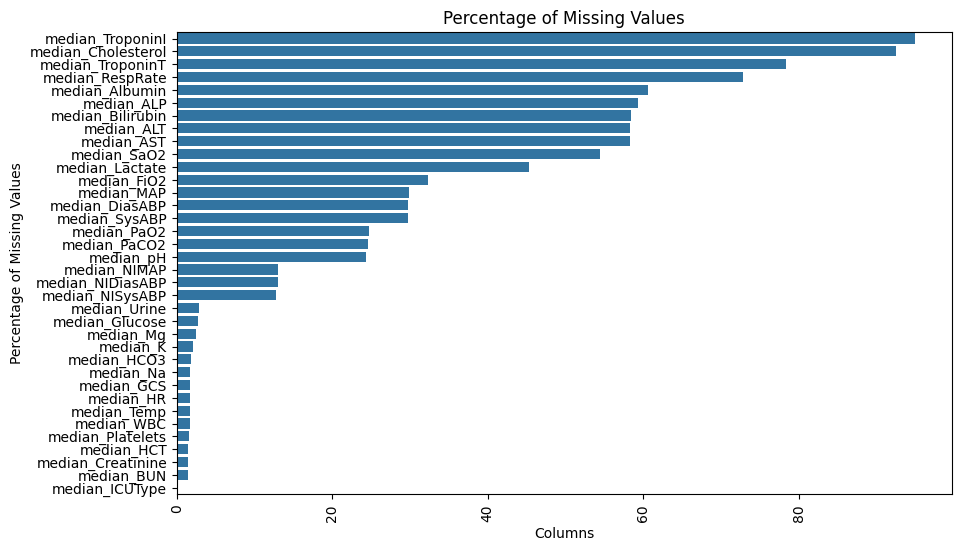

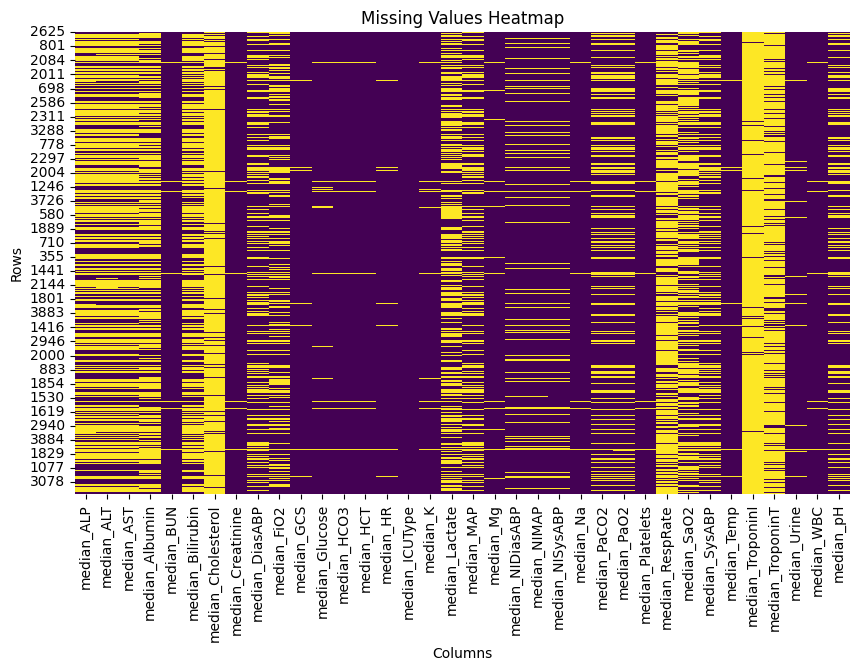

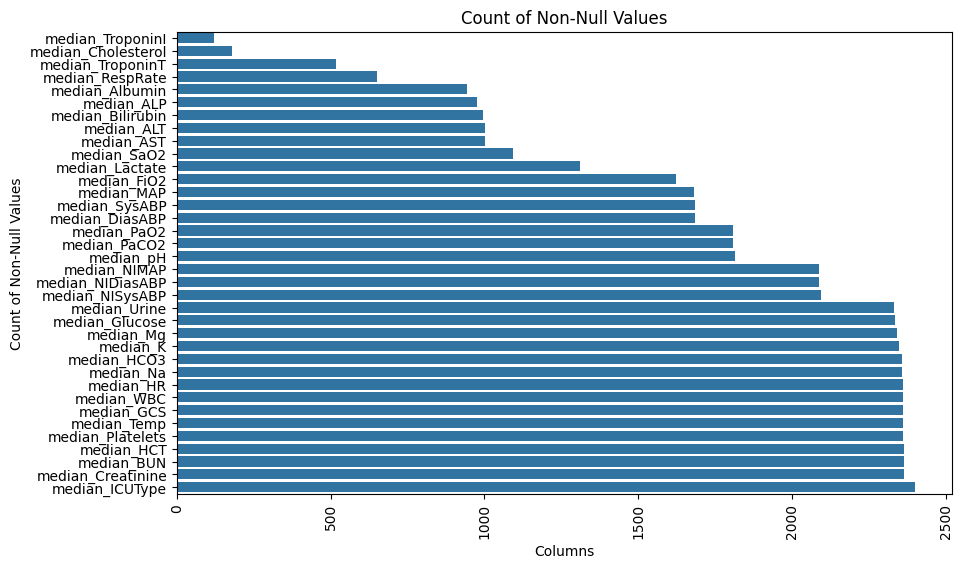

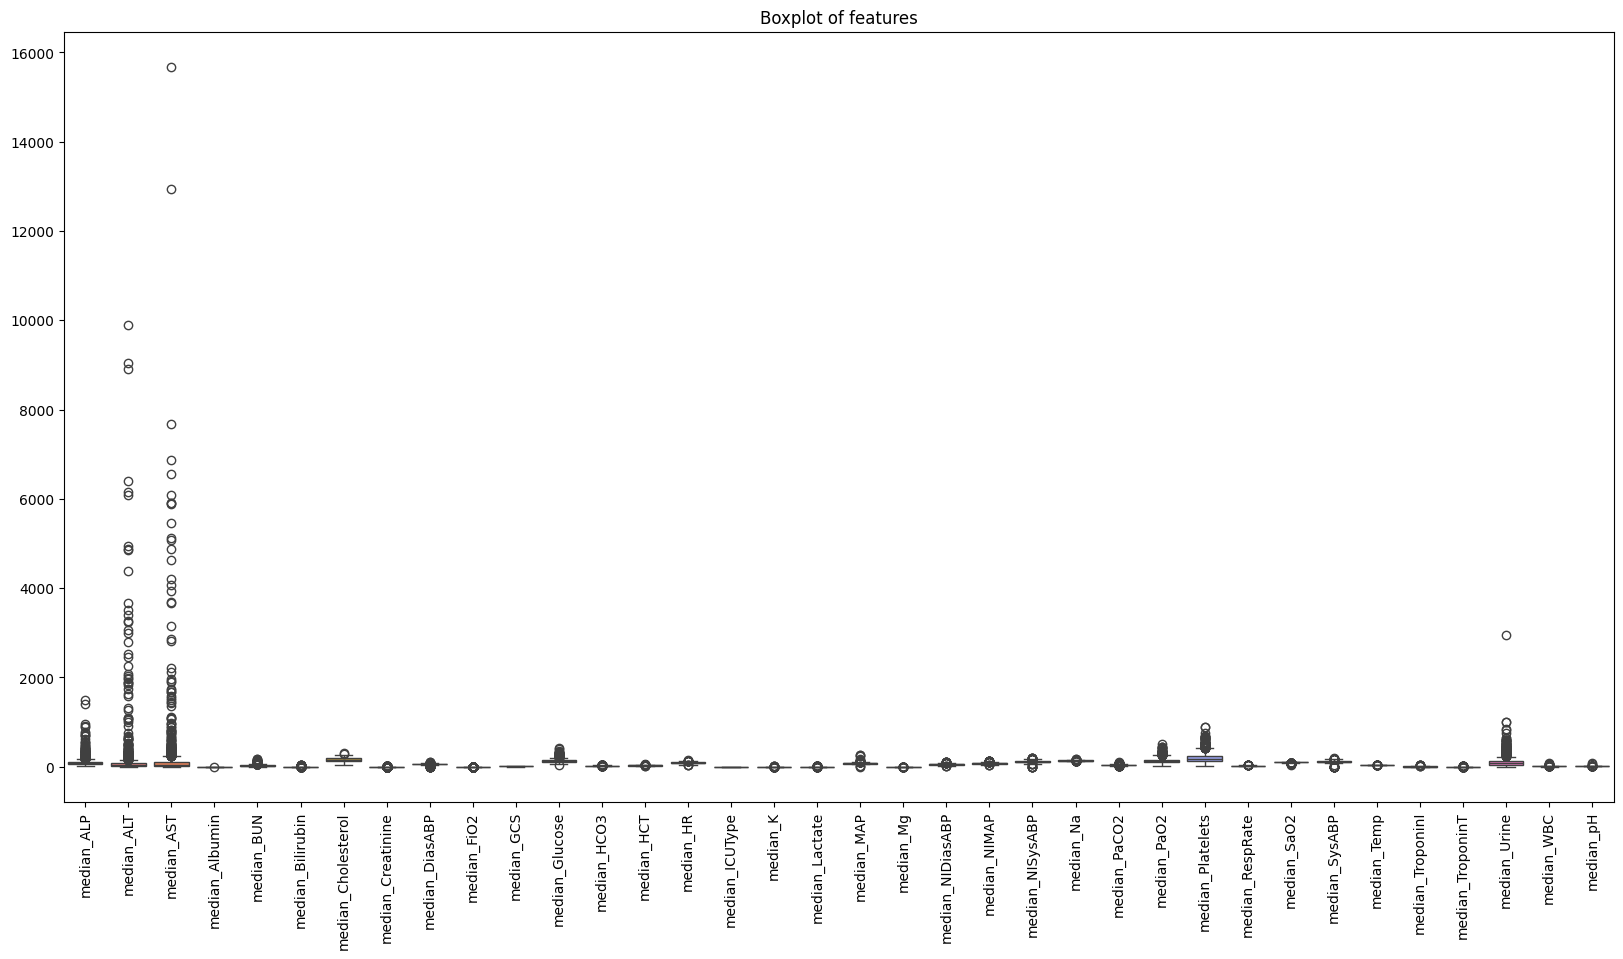

<Figure size 2000x1000 with 0 Axes>

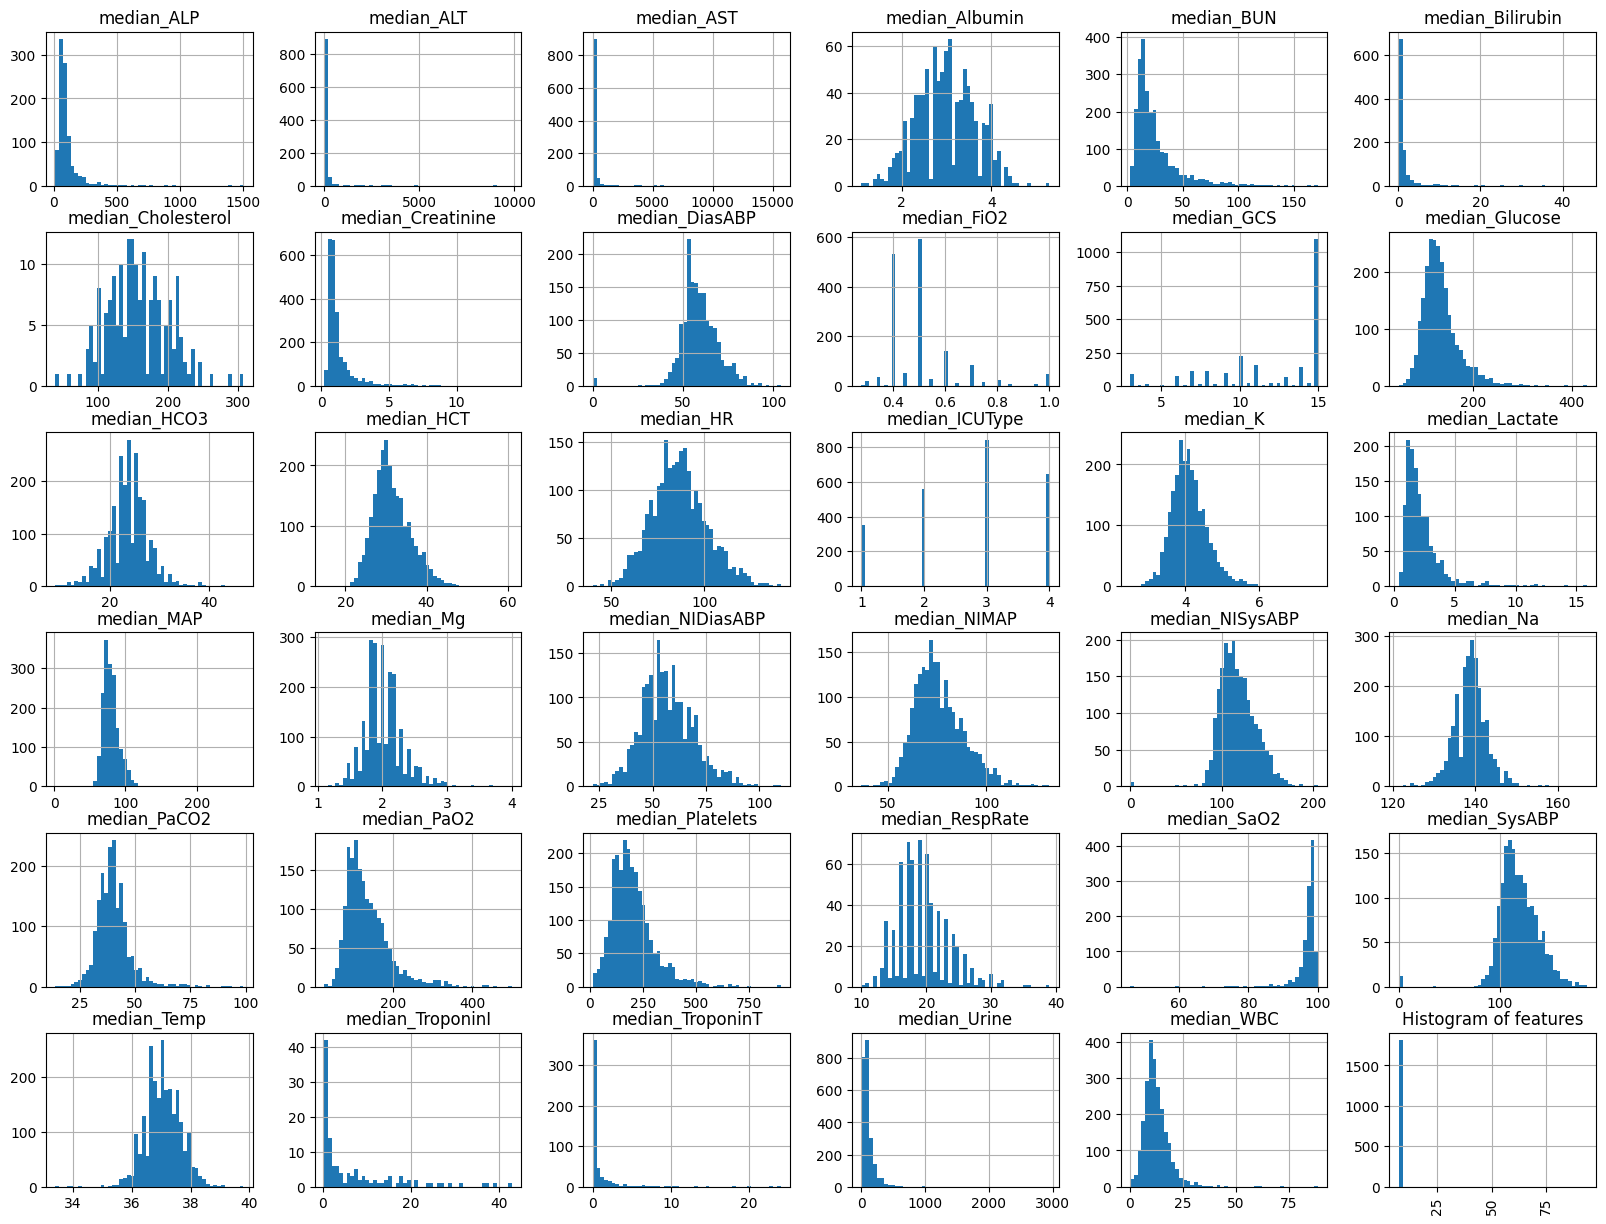

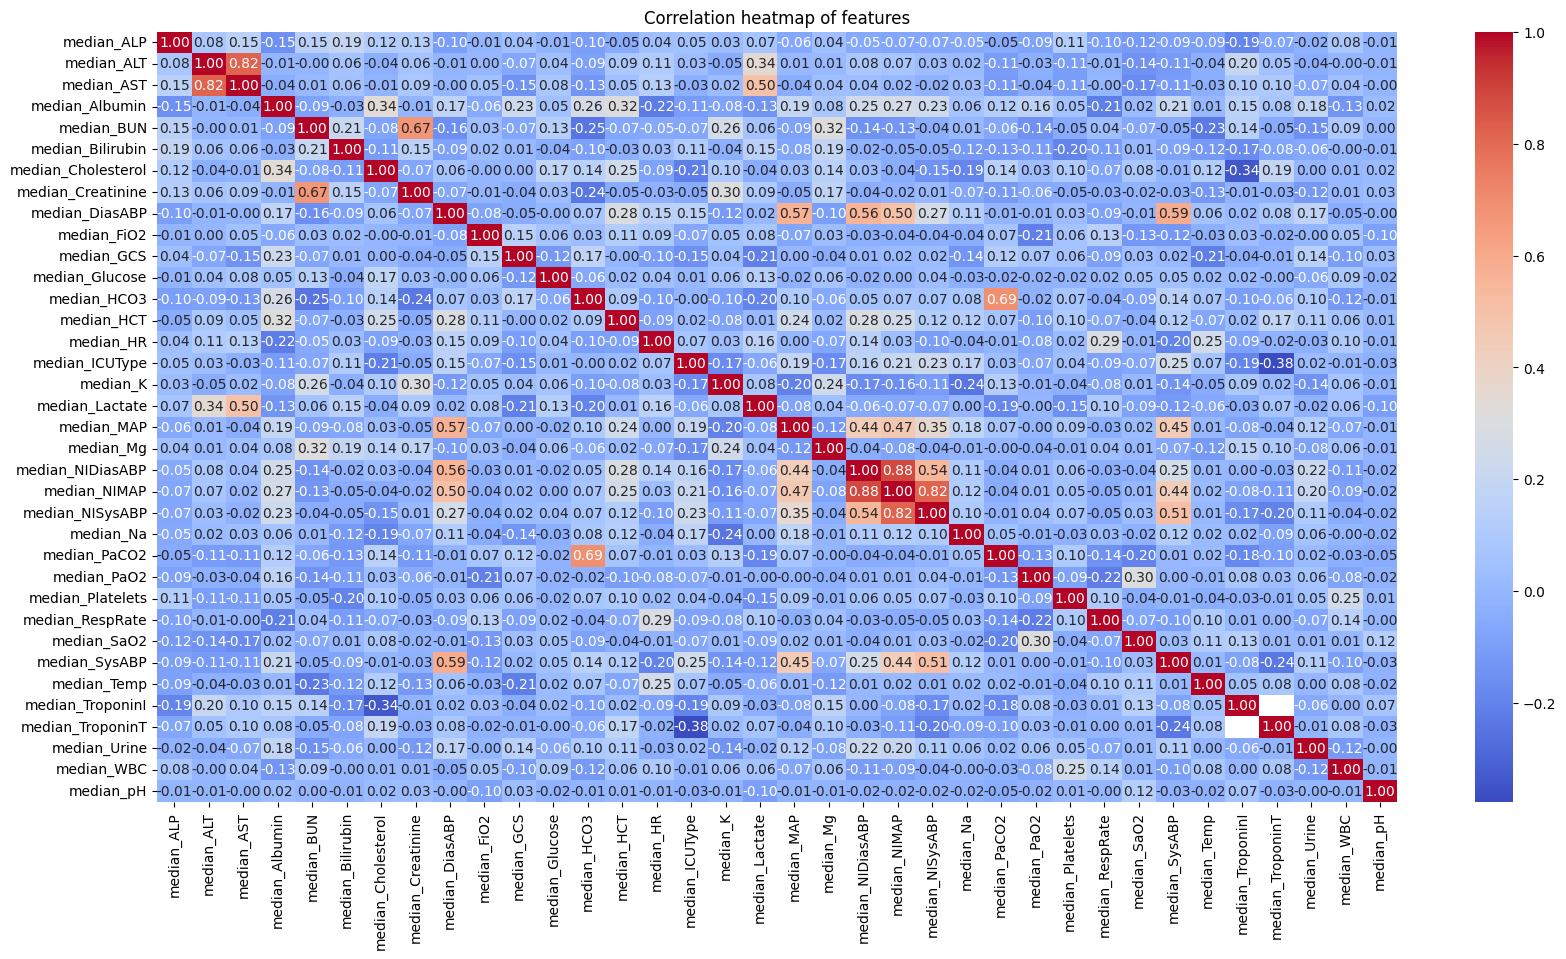

In [64]:
eda_on_df(X_train_cleaned[median_cols])

In [65]:
# there appear to be few highly correlated (>0.7) features
print_highly_correlated(X_train_cleaned[median_cols])

median_AST and median_ALT: 0.82
median_NIMAP and median_NIDiasABP: 0.88
median_NISysABP and median_NIMAP: 0.82


In [66]:
# subset medians from the splits and write it to a file for modeling
# non-stats cols list
non_stat_cols = ['MechVent', 'Age', 'Height','Weight']

X_train_cleaned_median = X_train_cleaned[get_colnames_with_prefix(X_train_cleaned,'median_')+ non_stat_cols]
X_test_cleaned_median = X_test_cleaned[get_colnames_with_prefix(X_test_cleaned, 'median_')+ non_stat_cols]
X_holdout_cleaned_median = X_holdout_cleaned[get_colnames_with_prefix(X_holdout_cleaned,'median_')+ non_stat_cols]
joblib.dump((X_train_cleaned_median, X_test_cleaned_median, X_holdout_cleaned_median,y_train, y_test, y_holdout), "../out_files/cleaned_splits/split_data_cleaned_median.joblib")


['../out_files/cleaned_splits/split_data_cleaned_median.joblib']

In [67]:
get_df_head_tail_shape(X_holdout_cleaned_median)
get_df_head_tail_shape(X_train_cleaned_median)


DataFrame Shape:
(800, 40)

DataFrame Head:
+------------+------------+------------+----------------+------------+------------------+--------------------+--------------------+----------------+-------------+------------+----------------+-------------+------------+-----------+----------------+----------+----------------+------------+-----------+------------------+--------------+-----------------+-----------+--------------+-------------+------------------+-----------------+-------------+---------------+-------------+------------------+------------------+--------------+------------+-----------+----------+------+--------+--------------------+
| median_ALP | median_ALT | median_AST | median_Albumin | median_BUN | median_Bilirubin | median_Cholesterol | median_Creatinine  | median_DiasABP | median_FiO2 | median_GCS | median_Glucose | median_HCO3 | median_HCT | median_HR | median_ICUType | median_K | median_Lactate | median_MAP | median_Mg | median_NIDiasABP | median_NIMAP | median_NISysABP |